In [1]:
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from joblib import load

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification


**Load Validation Data**

In [2]:
val_df = pd.read_csv("../data/processed/val_baseline.csv")

val_df = val_df[["text", "label"]]
val_df = val_df.dropna().reset_index(drop=True)

X_val_text = val_df["text"].tolist()
y_val = val_df["label"].values 


**Logistic Regression**

In [3]:
tfidf_vectorizer = load("../models/tfidf_vectorizer.pkl")
baseline_model = load("../models/baseline_logreg.pkl")

X_val_tfidf = tfidf_vectorizer.transform(X_val_text)
lr_preds = baseline_model.predict(X_val_tfidf)

**DistilBERT Models Setup**

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = DistilBertTokenizerFast.from_pretrained("../models/final_model")

In [5]:
model_p3 = DistilBertForSequenceClassification.from_pretrained(
    "../models/final_model"
).to(DEVICE)

model_p4 = DistilBertForSequenceClassification.from_pretrained(
    "../models/final_model_domain_adapted"
).to(DEVICE)

model_p3.eval()
model_p4.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


**Shared BERT Prediction Function**

In [11]:
from tqdm import tqdm
import torch
import numpy as np

def bert_predict_fast(model, texts, batch_size=8):
    model.eval()
    preds = []

    # Ensure list
    if not isinstance(texts, list):
        texts = texts.tolist()

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]

        encodings = tokenizer(
            batch_texts,
            truncation=True,
            padding=True,
            max_length=64,        # 🔥 CPU-friendly
            return_tensors="pt"
        )

        # Explicit CPU (important for EC2 / local)
        encodings = {k: v.cpu() for k, v in encodings.items()}

        with torch.no_grad():
            outputs = model(**encodings)
            batch_preds = torch.argmax(outputs.logits, dim=1)

        preds.extend(batch_preds.numpy())

    return np.array(preds)



**Generate Predictions**

BERT

In [12]:
DEVICE = torch.device("cpu")
model_p3.to(DEVICE)

bert_p3_preds = bert_predict_fast(
    model=model_p3,
    texts=X_val_text,
    batch_size=8
)


100%|██████████| 1314/1314 [15:34<00:00,  1.41it/s]


BERT+DA

In [13]:
model_p4.to(DEVICE)

bert_p4_preds = bert_predict_fast(
    model=model_p4,
    texts=X_val_text,
    batch_size=8
)


100%|██████████| 1314/1314 [19:58<00:00,  1.10it/s]


**Evaluation Function**

In [14]:
def evaluate_model(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Macro F1": f1_score(y_true, y_pred, average="macro"),
        "Weighted F1": f1_score(y_true, y_pred, average="weighted")
    }


**Collect Results (ALL THREE)**

In [15]:
results = []

results.append({
    "Model": "Logistic Regression (TF-IDF)",
    **evaluate_model(y_val, lr_preds)
})

results.append({
    "Model": "DistilBERT (Base)",
    **evaluate_model(y_val, bert_p3_preds)
})

results.append({
    "Model": "DistilBERT + Domain Adaptation",
    **evaluate_model(y_val, bert_p4_preds)
})


**Final Comparison Table**

In [16]:
comparison_df = pd.DataFrame(results)
comparison_df


,Model,Accuracy,Macro F1,Weighted F1
0,Logistic Regression (TF-IDF),0.758519,0.726939,0.758060
1,DistilBERT (Base),0.777175,0.743437,0.776439
2,DistilBERT + Domain Adaptation,0.769846,0.730817,0.763035


**Combined Visualization**

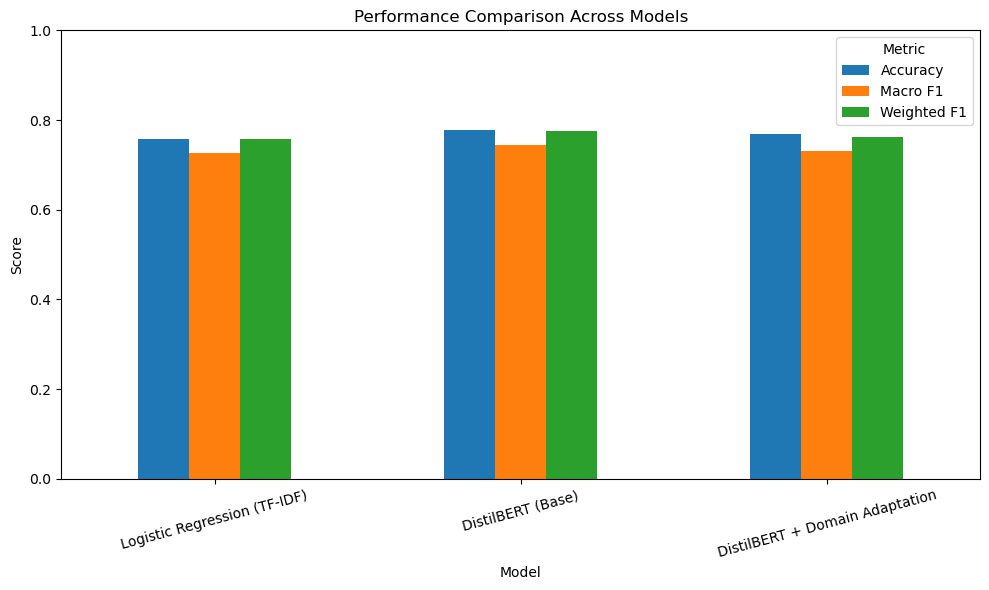

In [19]:
import matplotlib.pyplot as plt
metrics = ["Accuracy", "Macro F1", "Weighted F1"]

comparison_df.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Performance Comparison Across Models")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()
